The Data
The goal is to classify consumer finance complaints into 12 pre-defined classes. The data can be downloaded from data.gov:
https://catalog.data.gov/dataset/consumer-complaint-database




In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('/Users/piek/Desktop/data/consumer_complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.head(10)

,narrative,Product
0,transworld systems inc. \nis trying to collect...,Debt collection
2,I would like to request the suppression of the...,"Credit reporting, credit repair services, or o..."
4,"Over the past 2 weeks, I have been receiving e...",Debt collection
11,"I was sold access to an event digitally, of wh...","Money transfer, virtual currency, or money ser..."
12,While checking my credit report I noticed thre...,Debt collection
16,Today XX/XX/XXXX went online to dispute the in...,"Credit reporting, credit repair services, or o..."
18,XXXX is reporting incorrectly to Equifax and X...,"Credit reporting, credit repair services, or o..."
19,Please reverse the late payments reported on t...,"Credit reporting, credit repair services, or o..."
20,I would like the credit bureau to correct my X...,"Credit reporting, credit repair services, or o..."
21,MY NAME IS XXXX XXXX XXXX I live at XXXX XXXX ...,"Credit reporting, credit repair services, or o..."


In [2]:
df.shape

(497897, 2)

In [5]:
df.index = range(497897)
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

98166500

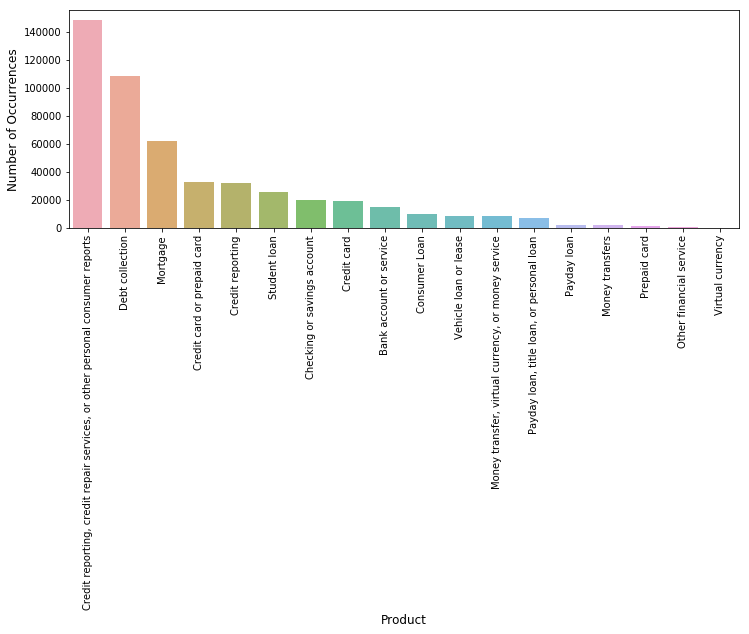

In [6]:
cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

The classes are imbalanced, however, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.


Let’s have a look a few examples of complaint narrative and its associated product.

In [7]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
print_complaint(12)

Spoke w XXXX XXXX XX/XX/19 XXXX XXXX cat at TransUnion. Refused to remove unauthorized inquiries from XXXX, XXXX XX/XX/19, XXXX XXXX XXXX.
Product: Credit reporting, credit repair services, or other personal consumer reports


In [8]:
print_complaint(20)

XXXX and Transunion are incorrectly reporting a charge-off account where I am shown as an Authorized User on the XXXX partial account number ****XXXX. ( Please see page attached from my credit report. ) I have already called the bank and let them know that I never gave permission to be added as an Authorized User on this account. This incorrect reporting of me as an authorized user is harming my credit score and this line item needs to be removed from my credit report. I have contacted the two bureaus to fix this issue, however I have not been successful.
Product: Credit reporting, credit repair services, or other personal consumer reports


## Text Preprocessing
Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.


In [9]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

The following steps include train/test split of 70/30, remove stop-words and tokenize text using NLTK tokenizer. For our first try we tag every complaint narrative with its product.

In [10]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

This is what a training entry looks like — an example complaint narrative tagged by “Credit reporting”.

In [11]:
train_tagged.values[30]

TaggedDocument(words=['this', 'involves', 'my', 'kohl', "'s", 'credit', 'card', 'have', 'paid', 'my', 'balance', 'in', 'full', 'and', 'interest', 'fees', 'was', 'told', 'by', 'kohl', "'s", 'my', 'late', 'fee', 'would', 'be', 'waived', 'but', 'it', 'has', 'not', 'and', 'more', 'late', 'fees', 'have', 'been', 'added', 'kohl', "'s", 'has', 'now', 'turned', 'the', 'balance', 'over', 'to', 'debt', 'collection', 'and', 'am', 'being', 'called', 'at', 'least', 'daily'], tags=['Credit card or prepaid card'])

## Set-up Doc2Vec Training & Evaluation Models
First, we instantiate a doc2vec model — Distributed Bag of Words (DBOW). In the word2vec architecture, the two algorithm names are “continuous bag of words” (CBOW) and “skip-gram” (SG); in the doc2vec architecture, the corresponding algorithms are “distributed memory” (DM) and “distributed bag of words” (DBOW).
## Distributed Bag of Words (DBOW)
DBOW is the doc2vec model analogous to Skip-gram model in word2vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.
We will vary the following parameters:
If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.
300- dimensional feature vectors.
min_count=2, ignores all words with total frequency lower than this.
negative=5 , specifies how many “noise words” should be drawn.
hs=0 , and negative is non-zero, negative sampling will be used.
sample=0 , the threshold for configuring which higher-frequency words are randomly down sampled.
workers=cores , use these many worker threads to train the model (=faster training with multicore machines).

In [12]:
import multiprocessing
cores = multiprocessing.cpu_count()

## Building a Vocabulary

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

Training a doc2vec model is rather straight-forward in Gensim, we initialize the model and train for 30 epochs.

In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

## Building the Final Vector Feature for the Classifier

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressorsdef vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

## Train the Logistic Regression Classifier.

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

## Distributed Memory (DM)


Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document. We again instantiate a Doc2Vec model with a vector size with 300 words and iterating over the training corpus 30 times.

In [ ]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

## Train the Logistic Regression Classifier

In [ ]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))